In [ ]:
!pip install open_clip_torch

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import open_clip
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tabulate import tabulate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_pretrained_clip(encoder_type, checkpoint_path):
  model, _, preprocess = open_clip.create_model_and_transforms(encoder_type, pretrained=checkpoint_path)
  model = model.to(device)
  return model, preprocess


def load_cifar10_data(root_dir, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match CLIP input size
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

    train_dataset = torchvision.datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    class_names = train_dataset.classes

    return train_loader, test_loader, class_names


def zero_shot_classification(model, test_loader, class_names, prompt_template):
    model.eval()
    text_inputs = open_clip.tokenize([prompt_template.format(class_name) for class_name in class_names]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)


    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits_per_image = image_features @ text_features.T
            probs = logits_per_image.softmax(dim=-1)
            _, predicted = torch.max(probs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    acc = 100 * correct / total
    return acc


def ensemble_classification(model, test_loader, class_names, prompt_templates):
    model.eval()
    text_features_list = []
    for prompt_template in prompt_templates:
        text_inputs = open_clip.tokenize([prompt_template.format(class_name) for class_name in class_names]).to(device)
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_features_list.append(text_features)

    ensemble_text_features = torch.stack(text_features_list, dim=0).mean(dim=0)
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits_per_image = image_features @ ensemble_text_features.T
            probs = logits_per_image.softmax(dim=-1)
            _, predicted = torch.max(probs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    acc = 100 * correct / total
    return acc

def linear_probe_classification(model, train_loader, test_loader):
    X_train = []
    y_train = []

    X_test= []
    y_test = []

    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(train_loader, desc='Extracting Train Features...'):
            images = images.to(device)
            img_features = model.encode_image(images)
            X_train.append(img_features.cpu().numpy())
            y_train.append(labels.cpu().numpy())

        for images,labels in tqdm(test_loader, desc='Extracting Test Features...'):
            images = images.to(device)
            img_features = model.encode_image(images)
            X_test.append(img_features.cpu().numpy())
            y_test.append(labels.cpu().numpy())


    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)
    acc = 100 * accuracy_score(y_pred, y_test)
    return acc


def visualize_and_compare(prompt_names, zero_shot_accuracies, linear_probe_accuracy, ensemble_accuracy):
    methods = prompt_names + ['Ensemble', 'Linear Probe']
    accuracies = zero_shot_accuracies + [ensemble_accuracy, linear_probe_accuracy]
    colors = ['skyblue'] * len(prompt_names) + ['lightgreen', 'salmon']
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods, accuracies, color=colors)
    plt.xlabel('Method / Prompt')
    plt.ylabel('Accuracy (%)')
    plt.title('Zero-Shot vs. Linear Probe Performance on CIFAR-10 (Open CLIP ViT-B-32)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{acc:.2f}%', ha='center')
    plt.tight_layout()
    plt.savefig('cifar10_comparison.png')
    plt.show()

    results = []
    for name, acc in zip(prompt_names, zero_shot_accuracies):
        results.append(['Zero-Shot', name, acc])
    results.append(['Zero-Shot', 'Ensemble', ensemble_accuracy])
    results.append(['Linear Probe', 'N/A', linear_probe_accuracy])
    headers = ['Method', 'Prompt', 'Accuracy (%)']
    print("\nResults Table:")
    print(tabulate(results, headers=headers, tablefmt='grid', floatfmt='.2f'))




def main(args):
    prompt_names = [prompt.replace('{}', '').strip().capitalize() for prompt in args['prompts']]

    model, _ = load_pretrained_clip(args['encoder'], args['checkpoint'])
    train_loader, test_loader, class_names = load_cifar10_data(args['data_dir'], args['batch_size'])

    print("\nComputing zero-shot accuracies...")
    zero_shot_accuracies = []
    for prompt_template, name in zip(args['prompts'], prompt_names):
        acc = zero_shot_classification(model, test_loader, class_names, prompt_template)
        zero_shot_accuracies.append(acc)
        print(f"Zero-shot accuracy with prompt '{prompt_template}': {acc:.2f}%")

    ensemble_accuracy = ensemble_classification(model, test_loader, class_names, args['prompts'])
    print(f"Ensemble accuracy: {ensemble_accuracy:.2f}%")

    print("\nComputing linear probe accuracy...")
    linear_probe_accuracy = linear_probe_classification(model, train_loader, test_loader)
    print(f"Linear probe accuracy: {linear_probe_accuracy:.2f}%")

    visualize_and_compare(prompt_names, zero_shot_accuracies, linear_probe_accuracy, ensemble_accuracy)


Computing zero-shot accuracies...
Zero-shot accuracy with prompt 'a photo of a {}': 90.10%
Zero-shot accuracy with prompt 'a picture of a {}': 89.95%
Zero-shot accuracy with prompt 'an image of a {}': 89.55%
Ensemble accuracy: 89.89%

Computing linear probe accuracy...


Extracting Test Features...: 100%|██████████| 79/79 [00:32<00:00,  2.47it/s]


Linear probe accuracy: 95.42%


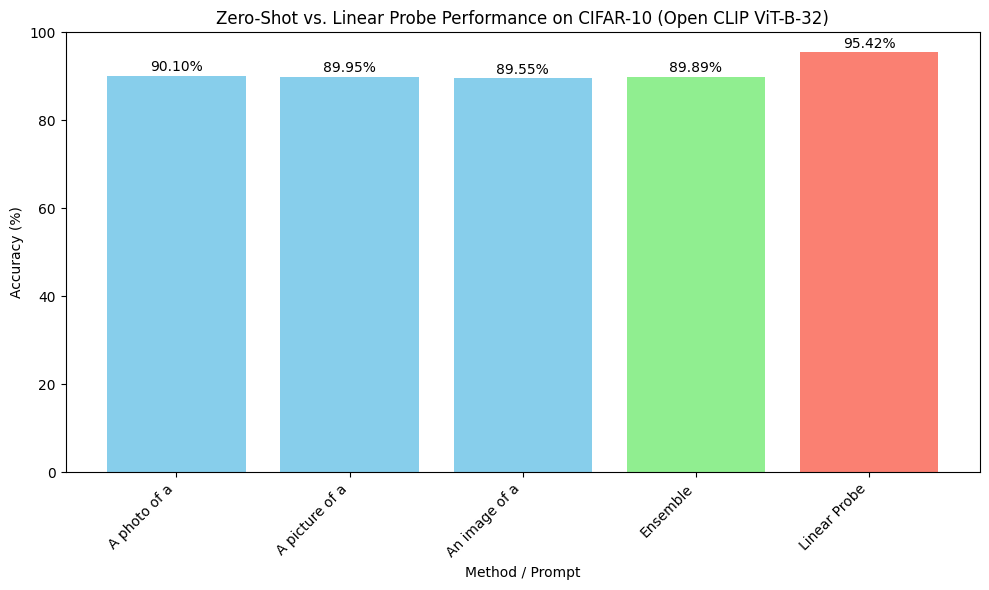


Results Table:
+--------------+----------------+----------------+
| Method       | Prompt         |   Accuracy (%) |
+==============+================+================+
| Zero-Shot    | A photo of a   |          90.10 |
+--------------+----------------+----------------+
| Zero-Shot    | A picture of a |          89.95 |
+--------------+----------------+----------------+
| Zero-Shot    | An image of a  |          89.55 |
+--------------+----------------+----------------+
| Zero-Shot    | Ensemble       |          89.89 |
+--------------+----------------+----------------+
| Linear Probe | N/A            |          95.42 |
+--------------+----------------+----------------+


In [ ]:
args = {
    'prompts': [
        'a photo of a {}',
        'a picture of a {}',
        'an image of a {}',
        'this is a {}',
        'a clear photo of a {}'
    ],
    'batch_size': 128,
    'data_dir': './data',
    'encoder': 'ViT-B-32',
    'checkpoint': 'laion2b_s34b_b79k',
}

main(args)